In [1]:
import numpy as np
import pandas as pd
import keras as k
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from keras.optimizers import Adam, SGD, RMSprop

Using TensorFlow backend.


In [174]:
# Load MNIST dataset
MNIST = k.datasets.fashion_mnist.load_data()
# Seperate dataset
training = MNIST[0]
X_train = training[0]
y_train = pd.Series(training[1], name="training targets")
testing = MNIST[1]
X_test = testing[0]
y_test = pd.Series(testing[1], name="testing targets")
# Keep only 1s and 0s for binary classification problem
y_train = y_train[(y_train == 0) | (y_train == 1)]
X_train = X_train[y_train.index]
y_test = y_test[(y_test == 0) | (y_test == 1)]
X_test = X_test[y_test.index]

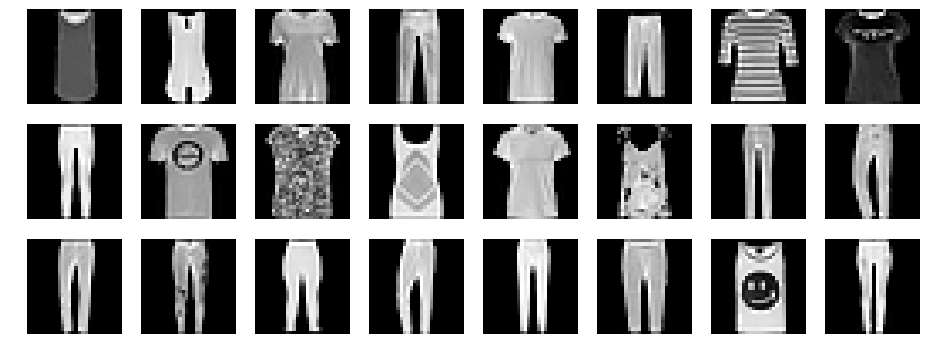

In [175]:
# Visualize training data
plt.figure(figsize=(16,6))
for i in range(24):
    fig = plt.subplot(3, 8, i+1)
    fig.set_axis_off()
    plt.imshow(X_train[i+1], cmap='gray')

In [194]:
keras_model = k.Sequential([
    k.layers.InputLayer(input_shape=(28,28,1)),
    k.layers.Conv2D(filters=16, kernel_size=3, activation="relu"),
    k.layers.Conv2D(filters=8, kernel_size=3, activation="relu"),
    k.layers.Flatten(),
    k.layers.Dense(16, activation="relu"),
    k.layers.Dense(16, activation="relu"),
    k.layers.Dense(16, activation="relu"),
    k.layers.Dense(1, activation="sigmoid")
])
keras_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_54 (Conv2D)           (None, 26, 26, 16)        160       
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 24, 24, 8)         1160      
_________________________________________________________________
flatten_35 (Flatten)         (None, 4608)              0         
_________________________________________________________________
dense_123 (Dense)            (None, 16)                73744     
_________________________________________________________________
dense_124 (Dense)            (None, 16)                272       
_________________________________________________________________
dense_125 (Dense)            (None, 16)                272       
_________________________________________________________________
dense_126 (Dense)            (None, 1)                 17        
Total para

In [195]:
# Select only m samples for fast training time during debugging
m = 1000
X = X_train[:m, :, :].reshape((m, 28, 28, 1))
y = y_train[:m].values.reshape(1,m)
# Compile model
keras_model.compile(optimizer=SGD(lr=0.001), loss='binary_crossentropy')
# Train model
history = keras_model.fit(x=X, y=y.flatten(), epochs=10)

Epoch 1/10
1000/1000 [==============================] - 3s 3ms/step - loss: 0.3578
Epoch 2/10
1000/1000 [==============================] - 0s 191us/step - loss: 0.1190
Epoch 3/10
1000/1000 [==============================] - 0s 200us/step - loss: 0.0721
Epoch 4/10
1000/1000 [==============================] - 0s 195us/step - loss: 0.0686
Epoch 5/10
1000/1000 [==============================] - 0s 214us/step - loss: 0.0586
Epoch 6/10
1000/1000 [==============================] - 0s 217us/step - loss: 0.0584
Epoch 7/10
1000/1000 [==============================] - 0s 220us/step - loss: 0.0532
Epoch 8/10
1000/1000 [==============================] - 0s 222us/step - loss: 0.0486
Epoch 9/10
1000/1000 [==============================] - 0s 210us/step - loss: 0.0452
Epoch 10/10
1000/1000 [==============================] - 0s 222us/step - loss: 0.0410


In [120]:
m = 1000
X = X_test[:m, :, :].reshape((m, 28, 28, 1))
y = y_test[:m].values.reshape(1,m)

predictions = keras_model.predict_classes(X)
accuracy_score(predictions, y.flatten())

0.787

In [114]:
def conv_single_step(a_slice_prev, W, b):
    """
    Apply one filter defined by parameters W on a single slice (a_slice_prev) of the output activation 
    of the previous layer.
    
    Arguments:
    a_slice_prev -- slice of input data of shape (f, f, n_C_prev)
    W -- Weight parameters contained in a window - matrix of shape (f, f, n_C_prev)
    b -- Bias parameters contained in a window - matrix of shape (1, 1, 1)
    
    Returns:
    Z -- a scalar value, the result of convolving the sliding window (W, b) on a slice x of the input data
    """
    
    # Element-wise product between a_slice_prev and W. Do not add the bias yet.
    s = np.multiply(a_slice_prev, W)
    # Sum over all entries of the volume s.
    Z = np.sum(s)
    # Add bias b to Z. Cast b to a float() so that Z results in a scalar value.
    Z = Z + float(b)

    return Z

def conv_forward(A_prev, W, b):
    """
    Implements the forward propagation for a convolution function
    
    Arguments:
    A_prev -- output activations of the previous layer, 
        numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
    W -- Weights, numpy array of shape (f, f, n_C_prev, n_C)
    b -- Biases, numpy array of shape (1, 1, 1, n_C)
        
    Returns:
    Z -- conv output, numpy array of shape (m, n_H, n_W, n_C)
    cache -- cache of values needed for the conv_backward() function
    """
    
    # Retrieve dimensions from A_prev's shape
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    # Retrieve dimensions from W's shape
    (f, f, n_C_prev, n_C) = W.shape
    
    # Compute the dimensions of the CONV output volume 
    n_H = n_H_prev - f + 1
    n_W = n_W_prev - f + 1
    
    # Initialize the output volume Z.
    Z = np.zeros([m, n_H, n_W, n_C])
    
    for i in range(m):   # loop over the batch of training examples
       
        # Select ith training example's activation
        a_prev = A_prev[i]
       
        for h in range(n_H):           # loop over vertical axis of the output volume
            for w in range(n_W):       # loop over horizontal axis of the output volume
                for c in range(n_C):   # loop over channels (= #filters) of the output volume
                    
                    vert_start = h
                    vert_end = vert_start + f
                    horiz_start = w
                    horiz_end = horiz_start + f
                                        
                    # Use the corners to define the (3D) slice of a_prev_pad 
                    a_slice_prev = A_prev[i, vert_start:vert_end, horiz_start:horiz_end, :]
                    
                    # Convolve the (3D) slice with the correct filter W and bias b, to get back one output neuron.
                    weights = W[:, :, :, c]
                    biases = b[:, :, :, c]
                    Z[i, h, w, c] = conv_single_step(a_slice_prev, weights, biases)
                                        
    
    # Making sure your output shape is correct
    assert(Z.shape == (m, n_H, n_W, n_C))
    
    # Save information in "cache" for the backprop
    cache = (A_prev, W, b)
    
    return Z, cache


def conv_backward(dZ, cache):
    """
    Implement the backward propagation for a convolution function
    Arguments:
    dZ -- gradient of the cost with respect to the output of the conv layer (Z), numpy array of shape (m, n_H, n_W, n_C)
    cache -- cache of values needed for the conv_backward(), output of conv_forward()
    Returns:
    dA_prev -- gradient of the cost with respect to the input of the conv layer (A_prev),
               numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
    dW -- gradient of the cost with respect to the weights of the conv layer (W)
          numpy array of shape (f, f, n_C_prev, n_C)
    db -- gradient of the cost with respect to the biases of the conv layer (b)
          numpy array of shape (1, 1, 1, n_C)
    """

    # Retrieve information from "cache"
    (A_prev, W, b) = cache

    # Retrieve dimensions from A_prev's shape
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape

    # Retrieve dimensions from W's shape
    (f, f, n_C_prev, n_C) = W.shape

    # Retrieve dimensions from dZ's shape
    (m, n_H, n_W, n_C) = dZ.shape

    # Initialize dA_prev, dW, db with the correct shapes
    dA_prev = np.zeros((m, n_H_prev, n_W_prev, n_C_prev))
    dW = np.zeros((f, f, n_C_prev, n_C))
    db = np.zeros((1, 1, 1, n_C))

    for i in range(m):  # loop over the training examples

        # select ith training example from A_prev and dA_prev
        a_prev = A_prev[i, :, :, :]
        da_prev = dA_prev[i, :, :, :]

        for h in range(n_H):  # loop over vertical axis of the output volume
            for w in range(n_W):  # loop over horizontal axis of the output volume
                for c in range(n_C):  # loop over the channels of the output volume

                    # Find the corners of the current "slice"
                    vert_start = h
                    vert_end = h + f
                    horiz_start = w
                    horiz_end = w + f

                    # Use the corners to define the slice from a_prev
                    a_slice = a_prev[vert_start:vert_end, horiz_start:horiz_end, :]

                    # Update gradients for the window and the filter's parameters
                    da_prev[vert_start:vert_end, horiz_start:horiz_end, :] += W[:, :, :, c] * dZ[i, h, w, c]
                    dW[:, :, :, c] += a_slice * dZ[i, h, w, c]
                    db[:, :, :, c] += dZ[i, h, w, c]

        # Set the ith training example's dA_prev
        dA_prev[i, :, :, :] = da_prev

    # Making sure your output shape is correct
    assert (dA_prev.shape == (m, n_H_prev, n_W_prev, n_C_prev))

    return dA_prev, dW, db

def flatten(A_prev):
    m, *shape = A_prev.shape
    return A_prev.reshape(m, np.prod(shape)).T, A_prev.shape

In [5]:
def sigmoid(Z):
    """
    Implements the sigmoid activation in numpy
    
    Arguments:
    Z -- numpy array of any shape
    
    Returns:
    A -- output of sigmoid(z), same shape as Z
    cache -- returns Z as well, useful during backpropagation
    """
    
    A = 1/(1+np.exp(-Z))
    cache = Z
    
    return A, cache

def relu(Z):
    """
    Implement the RELU function.
    Arguments:
    Z -- Output of the linear layer, of any shape
    Returns:
    A -- Post-activation parameter, of the same shape as Z
    cache -- a python dictionary containing "A" ; stored for computing the backward pass efficiently
    """
    
    A = np.maximum(0,Z)
    
    assert(A.shape == Z.shape)
    
    cache = Z 
    return A, cache


def relu_backward(dA, cache):
    """
    Implement the backward propagation for a single RELU unit.
    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently
    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    
    Z = cache
    dZ = np.array(dA, copy=True) # just converting dz to a correct object.
    
    # When z <= 0, you should set dz to 0 as well. 
    dZ[Z <= 0] = 0
    
    assert (dZ.shape == Z.shape)
    
    return dZ

def sigmoid_backward(dA, cache):
    """
    Implement the backward propagation for a single SIGMOID unit.
    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently
    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    
    Z = cache
    
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    
    assert (dZ.shape == Z.shape)
    
    return dZ

def initialize_parameters_deep(layer_dims):
    """
    Arguments:
    layer_dims -- python array (list) containing the dimensions of each layer in our network
    
    Returns:
    parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                    Wl -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                    bl -- bias vector of shape (layer_dims[l], 1)
    """
    
    np.random.seed(3)
    parameters = {}
    L = len(layer_dims)            # number of layers in the network

    for l in range(1, L):
        ### START CODE HERE ### (≈ 2 lines of code)
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * 0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        ### END CODE HERE ###
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))

        
    return parameters

def linear_forward(A, W, b):
    """
    Implement the linear part of a layer's forward propagation.

    Arguments:
    A -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)

    Returns:
    Z -- the input of the activation function, also called pre-activation parameter 
    cache -- a python tuple containing "A", "W" and "b" ; stored for computing the backward pass efficiently
    """
    
    ### START CODE HERE ### (≈ 1 line of code)
    Z = np.dot(W, A) + b
    ### END CODE HERE ###
    
    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)
    
    return Z, cache


def linear_activation_forward(A_prev, W, b, activation):
    """
    Implement the forward propagation for the LINEAR->ACTIVATION layer

    Arguments:
    A_prev -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"

    Returns:
    A -- the output of the activation function, also called the post-activation value 
    cache -- a python tuple containing "linear_cache" and "activation_cache";
             stored for computing the backward pass efficiently
    """
    
    if activation == "sigmoid":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        ### START CODE HERE ### (≈ 2 lines of code)
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
        ### END CODE HERE ###
    
    elif activation == "relu":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        ### START CODE HERE ### (≈ 2 lines of code)
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
        ### END CODE HERE ###
    
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)

    return A, cache


def L_model_forward(X, parameters):
    """
    Implement forward propagation for the [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID computation
    
    Arguments:
    X -- data, numpy array of shape (input size, number of examples)
    parameters -- output of initialize_parameters_deep()
    
    Returns:
    AL -- last post-activation value
    caches -- list of caches containing:
                every cache of linear_activation_forward() (there are L-1 of them, indexed from 0 to L-1)
    """

    caches = []
    A = X
    L = len(parameters) // 2                  # number of layers in the neural network
    
    # Implement [LINEAR -> RELU]*(L-1). Add "cache" to the "caches" list.
    for l in range(1, L):
        A_prev = A 
        ### START CODE HERE ### (≈ 2 lines of code)
        A, cache = linear_activation_forward(A_prev, parameters['W'+str(l)], parameters['b'+str(l)], activation="relu")
        caches.append(cache)
        ### END CODE HERE ###
    
    # Implement LINEAR -> SIGMOID. Add "cache" to the "caches" list.
    ### START CODE HERE ### (≈ 2 lines of code)
    AL, cache = linear_activation_forward(A, parameters['W'+str(L)], parameters['b'+str(L)], activation="sigmoid")
    caches.append(cache)
    ### END CODE HERE ###
    
    assert(AL.shape == (1,X.shape[1]))
            
    return AL, caches


def linear_backward(dZ, cache):
    """
    Implement the linear portion of backward propagation for a single layer (layer l)

    Arguments:
    dZ -- Gradient of the cost with respect to the linear output (of current layer l)
    cache -- tuple of values (A_prev, W, b) coming from the forward propagation in the current layer

    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    A_prev, W, b = cache
    m = A_prev.shape[1]

    ### START CODE HERE ### (≈ 3 lines of code)
    dW = 1/m*np.dot(dZ, A_prev.T)
    db = 1/m*np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)
    ### END CODE HERE ###
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_prev, dW, db


def linear_activation_backward(dA, cache, activation):
    """
    Implement the backward propagation for the LINEAR->ACTIVATION layer.
    
    Arguments:
    dA -- post-activation gradient for current layer l 
    cache -- tuple of values (linear_cache, activation_cache) we store for computing backward propagation efficiently
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"
    
    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        ### START CODE HERE ### (≈ 2 lines of code)
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        ### END CODE HERE ###
        
    elif activation == "sigmoid":
        ### START CODE HERE ### (≈ 2 lines of code)
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        ### END CODE HERE ###
    
    return dA_prev, dW, db


def L_model_backward(AL, Y, caches):
    """
    Implement the backward propagation for the [LINEAR->RELU] * (L-1) -> LINEAR -> SIGMOID group
    
    Arguments:
    AL -- probability vector, output of the forward propagation (L_model_forward())
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat)
    caches -- list of caches containing:
                every cache of linear_activation_forward() with "relu" (it's caches[l], for l in range(L-1) i.e l = 0...L-2)
                the cache of linear_activation_forward() with "sigmoid" (it's caches[L-1])
    
    Returns:
    grads -- A dictionary with the gradients
             grads["dA" + str(l)] = ... 
             grads["dW" + str(l)] = ...
             grads["db" + str(l)] = ... 
    """
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
    
    # Initializing the backpropagation
    ### START CODE HERE ### (1 line of code)
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL)) # derivative of cost with respect to AL
    ### END CODE HERE ###
    
    # Lth layer (SIGMOID -> LINEAR) gradients. Inputs: "dAL, current_cache". Outputs: "grads["dAL-1"], grads["dWL"], grads["dbL"]
    ### START CODE HERE ### (approx. 2 lines)
    #grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = None
    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, "sigmoid")
    ### END CODE HERE ###
    
    # Loop from l=L-2 to l=0
    for l in reversed(range(L-1)):
        # lth layer: (RELU -> LINEAR) gradients.
        # Inputs: "grads["dA" + str(l + 1)], current_cache". Outputs: "grads["dA" + str(l)] , grads["dW" + str(l + 1)] , grads["db" + str(l + 1)] 
        ### START CODE HERE ### (approx. 5 lines)
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l+1)], current_cache, "relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp
        ### END CODE HERE ###

    return grads

def compute_cost(AL, Y):
    """
    Implement the cost function defined by equation (7).

    Arguments:
    AL -- probability vector corresponding to your label predictions, shape (1, number of examples)
    Y -- true "label" vector (for example: containing 0 if non-cat, 1 if cat), shape (1, number of examples)

    Returns:
    cost -- cross-entropy cost
    """
    m = Y.shape[1]

    # Compute loss from aL and y.
    ### START CODE HERE ### (≈ 1 lines of code)
    logprods = np.dot(Y, np.log(AL).T) + np.dot((1-Y), np.log(1-AL).T)
    cost = -1/m*np.sum(logprods)
    ### END CODE HERE ###
    
    cost = np.squeeze(cost)      # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).
    assert(cost.shape == ())
    
    return cost

def update_parameters(parameters, grads, learning_rate):
    """
    Update parameters using gradient descent
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients, output of L_model_backward
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
                  parameters["W" + str(l)] = ... 
                  parameters["b" + str(l)] = ...
    """
    
    L = len(parameters) // 2 # number of layers in the neural network

    # Update rule for each parameter. Use a for loop.
    ### START CODE HERE ### (≈ 3 lines of code)
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)]-learning_rate*grads["dW" + str(l + 1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)]-learning_rate*grads["db" + str(l + 1)]
    ### END CODE HERE ###
    return parameters

In [6]:
# GRADED FUNCTION: L_layer_model

def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- data, numpy array of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    np.random.seed(1)
    costs = []                         # keep track of cost
    
    # Parameters initialization. (≈ 1 line of code)
    ### START CODE HERE ###
    parameters = initialize_parameters_deep(layers_dims)
    ### END CODE HERE ###
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        ### START CODE HERE ### (≈ 1 line of code)
        AL, caches = L_model_forward(X, parameters)
        ### END CODE HERE ###
        
        # Compute cost.
        ### START CODE HERE ### (≈ 1 line of code)
        cost = compute_cost(AL, Y)
        ### END CODE HERE ###
    
        # Backward propagation.
        ### START CODE HERE ### (≈ 1 line of code)
        grads = L_model_backward(AL, Y, caches)
        ### END CODE HERE ###
 
        # Update parameters.
        ### START CODE HERE ### (≈ 1 line of code)
        parameters = update_parameters(parameters, grads, learning_rate)
        ### END CODE HERE ###
                
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

In [51]:
X = X_train[:200, :, :].reshape((200, 28, 28, 1))
y = y_train[:200].values.reshape(1,200)

In [23]:
"""
Conv2D_1 -> filters=16, kernal_size=3, activation="relu" (None, 26, 26, 16) #160
Flatten_1 -> (None, 10816)
Dense_1 -> units=32, activation="relu" (None, 32) #346144
Dense_2 -> units=1, activation="sigmoid" (None, 1) #33
"""
def CNN(X, Y, epochs, learning_rate=0.001):
    
    # Initialize parameters
    parameters = dict()
    parameters["ConvW1"] = np.random.randn(3, 3, 1, 16) * 0.01
    parameters["Convb1"] = np.zeros((1,1,1,16))
    parameters["W1"] = np.random.randn(32, 10816) * 0.01
    parameters["b1"] = np.zeros((32,1))
    parameters["W2"] = np.random.randn(1, 32) * 0.01
    parameters["b2"] = np.zeros((1,1))
    
    for epoch in range(epochs):
        Z, cache_conv1 = conv_forward(X, parameters["ConvW1"], parameters["Convb1"])
        Z, cache_relu1 = relu(Z) # apply relu activation function
        Z, cache_flatten1 = flatten(Z) # flatten activation and store previous shape
        Z, cache_dense1 = linear_activation_forward(Z, parameters["W1"], parameters["b1"], "relu")
        AL, cache_dense2 = linear_activation_forward(Z, parameters["W2"], parameters["b2"], "sigmoid")
        cost = compute_cost(AL, Y)
        print("Cost epoch ", epoch, ": ", cost, sep="")
        grads = dict()
        dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL)) # derivative of cost with respect to AL
        grads["dA2"], grads["dW2"], grads["db2"] = linear_activation_backward(dAL, cache_dense2, "sigmoid")
        grads["dA1"], grads["dW1"], grads["db1"] = linear_activation_backward(grads["dA2"], cache_dense1, "relu")
        grads["flatten1"] = grads["dA1"].reshape(cache_flatten1)
        grads["relu1"] = relu_backward(grads["flatten1"], cache_relu1)
        grads["dConvA1"], grads["dConvW1"], grads["dConvb1"] = conv_backward(grads["relu1"], cache_conv1)
        
        parameters["ConvW1"] = parameters["ConvW1"]-learning_rate*grads["dConvW1"]
        parameters["Convb1"] = parameters["Convb1"]-learning_rate*grads["dConvb1"]
        parameters["W1"] = parameters["W1"]-learning_rate*grads["dW1"]
        parameters["b1"] = parameters["b1"]-learning_rate*grads["db1"]
        parameters["W2"] = parameters["W2"]-learning_rate*grads["dW2"]
        parameters["b2"] = parameters["b2"]-learning_rate*grads["db2"]
        
    return parameters, AL

def predict(X, parameters):
    Z, cache_conv1 = conv_forward(X, parameters["ConvW1"], parameters["Convb1"])
    Z, cache_relu1 = relu(Z) # apply relu activation function
    Z, cache_flatten1 = flatten(Z) # flatten activation and store previous shape
    Z, cache_dense1 = linear_activation_forward(Z, parameters["W1"], parameters["b1"], "relu")
    AL, cache_dense2 = linear_activation_forward(Z, parameters["W2"], parameters["b2"], "sigmoid")
    return AL

In [ ]:
parameters, AL = CNN(X,y, epochs=10, learning_rate=0.001)

Cost epoch 0: 0.6825200198454259
Cost epoch 1: 0.6622611625597173
Cost epoch 2: 0.6002733147172207
Cost epoch 3: 0.4338124892608679


In [30]:
accuracy_score(y.flatten(), AL.flatten().round())

0.994

In [50]:
X = X_test[:200, :, :].reshape((200, 28, 28, 1))
y = y_test[:200].values.reshape(1,200)
predictions = predict(X, parameters)

KeyboardInterrupt: 

In [32]:
accuracy_score(y.flatten(), predictions.flatten().round())

0.997

In [227]:
def sigmoid(Z):
    """
    Implements the sigmoid activation in numpy
    
    Arguments:
    Z -- numpy array of any shape
    
    Returns:
    A -- output of sigmoid(z), same shape as Z
    cache -- returns Z as well, useful during backpropagation
    """
    
    A = 1/(1+np.exp(-Z))
    cache = Z
    
    return A, cache

def relu(Z):
    """
    Implement the RELU function.
    Arguments:
    Z -- Output of the linear layer, of any shape
    Returns:
    A -- Post-activation parameter, of the same shape as Z
    cache -- a python dictionary containing "A" ; stored for computing the backward pass efficiently
    """
    
    A = np.maximum(0,Z)
    
    assert(A.shape == Z.shape)
    
    cache = Z 
    return A, cache


def relu_backward(dA, cache):
    """
    Implement the backward propagation for a single RELU unit.
    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently
    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    
    Z = cache
    dZ = np.array(dA, copy=True) # just converting dz to a correct object.
    
    # When z <= 0, you should set dz to 0 as well. 
    dZ[Z <= 0] = 0
    
    assert (dZ.shape == Z.shape)
    
    return dZ

def sigmoid_backward(dA, cache):
    """
    Implement the backward propagation for a single SIGMOID unit.
    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently
    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    
    Z = cache
    
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    
    assert (dZ.shape == Z.shape)
    
    return dZ

def compute_cost(AL, Y):
    """
    Implement the cost function defined by equation (7).

    Arguments:
    AL -- probability vector corresponding to your label predictions, shape (1, number of examples)
    Y -- true "label" vector (for example: containing 0 if non-cat, 1 if cat), shape (1, number of examples)

    Returns:
    cost -- cross-entropy cost
    """
    m = Y.shape[1]

    # Compute loss from aL and y.
    ### START CODE HERE ### (≈ 1 lines of code)
    logprods = np.dot(Y, np.log(AL).T) + np.dot((1-Y), np.log(1-AL).T)
    cost = -1/m*np.sum(logprods)
    ### END CODE HERE ###
    
    cost = np.squeeze(cost)      # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).
    assert(cost.shape == ())
    
    return cost

In [234]:
class Layer:
    """
    Interface for layers.
    """
    def __init__(self, input_shape: tuple, output_shape: tuple):
        self.input_shape = input_shape
        self.output_shape = output_shape
        
    def forward(self, A_prev):
        pass
    
    def backward(self, dZ):
        pass
    
    def update_params(self, learning_rate):
        pass
    
    def __str__(self):
        return self.__class__.__name__ + " " + str(output_shape)
    
    
class Dense(Layer):
    def __init__(self, neurons: int, input_shape: tuple, activation: str):
        """
        Constructor for Conv2D layer.
        
        Arguments:
        neurons (N) -- number of neurons
        input_shape -- (N_prev, m)
        activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"
        """
        output_shape = (input_shape[0], neurons)
        super().__init__(input_shape, output_shape)
        self.neurons = neurons
        self.activation = activation
        self.initialize_params()
        
    def initialize_params(self):
        '''
        Definitions:
        self.W -- Weights, numpy array of shape (N, N_prev)
        self.b -- Biases, numpy array of shape (N, 1)
        '''
        self.W = np.random.randn(self.neurons, self.input_shape[0]) * 0.01
        self.b = np.zeros((self.neurons,1))
        
        
    def forward(self, A_prev):
        """
        Implement the forward propagation for the dense layer with activation function

        Arguments:
        A_prev -- activations from previous layer (or input data): (size of previous layer, number of examples)

        Returns:
        A -- the output of the activation function, also called the post-activation value 
        
        Defintions:
        self.cache -- tuple of values (A_prev, activation_cache) stored for computing backward propagation efficiently

        """
        Z = np.dot(self.W, A_prev) + self.b
        if self.activation == "sigmoid":
            A, activation_cache = sigmoid(Z)

        elif self.activation == "relu":
            A, activation_cache = relu(Z)

        assert (A.shape == (self.W.shape[0], A_prev.shape[1]))
        self.cache = (A_prev, activation_cache)

        return A
    
    def backward(self, dA):
        """
        Implement the backward propagation for the dense layer with activation function

        Arguments:
        dA -- post-activation gradient for current layer l 
       
        Returns:
        dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
        
        Definitions:
        self.dW -- Gradient of the cost with respect to W (current layer l), same shape as W
        self.db -- Gradient of the cost with respect to b (current layer l), same shape as b
        """
        A_prev, activation_cache = self.cache
        m = A_prev.shape[1]

        if self.activation == "relu":
            dZ = relu_backward(dA, activation_cache)
        elif self.activation == "sigmoid":
            dZ = sigmoid_backward(dA, activation_cache)
            
        self.dW = 1/m*np.dot(dZ, A_prev.T)
        self.db = 1/m*np.sum(dZ, axis=1, keepdims=True)
        dA_prev = np.dot(self.W.T, dZ)

        return dA_prev
    
    def update_params(self, learning_rate):
        self.W = self.W-learning_rate*self.dW
        self.b = self.b-learning_rate*self.db

        
class Conv2D(Layer):
    def __init__(self, filters: int, filter_size: int, input_shape: tuple):
        """
        Constructor for Conv2D layer.
        
        Arguments:
        filters (C) -- number of filters
        filter_size (f) -- size of filters
        input_shape -- (m, H, W, C)
        """
        output_shape = (input_shape[0], input_shape[1] - filter_size + 1, input_shape[2] - filter_size + 1, filters)
        super().__init__(input_shape, output_shape)
        self.filters = filters
        self.filter_size = filter_size
        self.initialize_params()
    
    def initialize_params(self):
        '''
        Definitions:
        self.W -- Weights, numpy array of shape (f, f, C_prev, n_C)
        self.b -- Biases, numpy array of shape (1, 1, 1, n_C)
        '''
        self.W = np.random.randn(self.filter_size, self.filter_size, self.input_shape[3], self.filters) * 0.01
        self.b = np.zeros((1,1,1,self.filters))
        

    def forward(self, A_prev):
        """
        Implements the forward propagation for a convolution function

        Arguments:
        A_prev -- output activations of the previous layer, numpy array of shape (m, H_prev, W_prev, C_prev)
        
        Returns:
        Z -- conv output
        """

        # Define dimensions
        assert(A_prev.shape[1:4] == self.input_shape[1:4])
        (m, H_prev, W_prev, C_prev) = A_prev.shape
        (_, H, W, C) = self.output_shape

        # Initialize the output volume Z.
        Z = np.zeros((m, H, W, C))

        for i in range(m):   # loop over the batch of training examples

            # Select ith training example's activation
            a_prev = A_prev[i]

            for h in range(H):           # loop over vertical axis of the output volume
                for w in range(W):       # loop over horizontal axis of the output volume
                    for c in range(C):   # loop over channels (= #filters) of the output volume

                        vert_start = h
                        vert_end = vert_start + self.filter_size
                        horiz_start = w
                        horiz_end = horiz_start + self.filter_size

                        # Use the corners to define the (3D) slice of a_prev_pad 
                        a_slice_prev = A_prev[i, vert_start:vert_end, horiz_start:horiz_end, :]

                        # Convolve the (3D) slice with the correct filter W and bias b, to get back one output neuron.
                        weights = self.W[:, :, :, c]
                        biases = self.b[:, :, :, c]
                        # Element-wise product between a_slice_prev and W.
                        s = np.multiply(a_slice_prev, weights)
                        # Sum over all entries of the volume s.
                        z = np.sum(s)
                        # Add bias b to z. Cast b to a float() so that z results in a scalar value.
                        z = z + float(biases)
                        Z[i, h, w, c] = z
        
        # Save information in "cache" for the backprop
        self.cache = A_prev
        # Return the output
        return Z
    
    
    def backward(self, dZ):
        """
        Implement the backward propagation for a convolution function
        
        Arguments:
        dZ -- gradient of the cost with respect to the output of the conv layer (Z), numpy array of shape (m, H, W, C)
        
        Returns:
        dA_prev -- gradient of the cost with respect to the input of the conv layer (A_prev),
                   numpy array of shape (m, H_prev, W_prev, C_prev)
                   
        Definitions:
        self.dW -- gradient of the cost with respect to the weights of the conv layer (W)
              numpy array of shape (f, f, C_prev, C)
        self.db -- gradient of the cost with respect to the biases of the conv layer (b)
              numpy array of shape (1, 1, 1, C)
        """

        # Retrieve information from "cache"
        A_prev = self.cache

        # Define dimensions
        assert(A_prev.shape[1:4] == self.input_shape[1:4])
        (m, H_prev, W_prev, C_prev) = A_prev.shape
        (_, H, W, C) = self.output_shape

        # Initialize dA_prev, dW, db with the correct shapes
        dA_prev = np.zeros((m, H_prev, W_prev, C_prev))
        self.dW = np.zeros(self.W.shape)
        self.db = np.zeros(self.b.shape)

        for i in range(m):  # loop over the training examples

            # select ith training example from A_prev and dA_prev
            a_prev = A_prev[i, :, :, :]
            da_prev = dA_prev[i, :, :, :]

            for h in range(H):  # loop over vertical axis of the output volume
                for w in range(W):  # loop over horizontal axis of the output volume
                    for c in range(C):  # loop over the channels of the output volume

                        # Find the corners of the current "slice"
                        vert_start = h
                        vert_end = h + self.filter_size
                        horiz_start = w
                        horiz_end = w + self.filter_size

                        # Use the corners to define the slice from a_prev
                        a_slice = a_prev[vert_start:vert_end, horiz_start:horiz_end, :]

                        # Update gradients for the window and the filter's parameters
                        da_prev[vert_start:vert_end, horiz_start:horiz_end, :] += self.W[:, :, :, c] * dZ[i, h, w, c]
                        self.dW[:, :, :, c] += a_slice * dZ[i, h, w, c]
                        self.db[:, :, :, c] += dZ[i, h, w, c]

            # Set the ith training example's dA_prev
            dA_prev[i, :, :, :] = da_prev
            
        return dA_prev
    
       
    def update_params(self, learning_rate):
        self.W = self.W-learning_rate*self.dW
        self.b = self.b-learning_rate*self.db

        
class ReLU(Layer):
    def __init__(self, input_shape):
        output_shape = input_shape
        super().__init__(input_shape, output_shape)
           
    def forward(self, Z):
        """
        Implement the RELU function.
        Arguments:
        Z -- Output of the linear layer, of any shape
        Returns:
        A -- Post-activation parameter, of the same shape as Z
        """

        A = np.maximum(0,Z)
        self.cache = Z 
        return A

    def backward(self, dA):
        """
        Implement the backward propagation for a single RELU unit.
        Arguments:
        dA -- post-activation gradient, of any shape
        Returns:
        dZ -- Gradient of the cost with respect to Z
        """

        Z = self.cache
        dZ = np.array(dA, copy=True) # just converting dz to a correct object.

        # When z <= 0, you should set dz to 0 as well. 
        dZ[Z <= 0] = 0

        return dZ
    

        
class Flatten(Layer):
    def __init__(self, input_shape):
        m, *shape = input_shape
        output_shape = (np.prod(shape), m)
        super().__init__(input_shape, output_shape)
        
    def forward(self, A_prev):
        m, *shape = A_prev.shape
        self.cache = A_prev.shape
        return A_prev.reshape(m, np.prod(shape)).T
    
    def backward(self, dZ):
        return dZ.reshape(self.cache)
    
        
class Model:
    def __init__(self, layers: list):
        self.layers = layers
        self.parameters = dict()
        
    def fit(self, X, Y, epochs, learning_rate, verbose): 
        # Initialize parameters
        history = list()
        for epoch in range(epochs):
            # FORWARD PROP
            Z = X
            for layer in self.layers:
                Z = layer.forward(Z)
            
            # COST FUNCTION
            cost = compute_cost(Z, Y)
            history.append(cost)
            if verbose == 1:
                print("Cost epoch ", epoch, ": ", cost, sep="")

            # BACKWARD PROP
            dA = - (np.divide(Y, Z) - np.divide(1 - Y, 1 - Z)) # derivative of cost with respect to AL
            
            for layer in reversed(self.layers):
                dA = layer.backward(dA)
            
            # UPDATE PARAMS
            for layer in self.layers:
                layer.update_params(learning_rate)

        return history
    
    def predict(self, X):
        Z = X
        for layer in self.layers:
            Z = layer.forward(Z)
        return Z
    
    def summary(self):
        print("--------------------")
        for layer in layers:
            print(layer)
            print("--------------------")
            
    
        

In [243]:
# Select only m samples for fast training time during debugging
m = 10
X = X_train[:m, :, :].reshape((m, 28, 28, 1))
y = y_train[:m].values.reshape(1,m)
# Define the layers of the model
layers = [
    Conv2D(16, 3, (None, 28, 28, 1)),
    ReLU((None, 26, 26, 16)),
    Conv2D(16, 3, (None, 26, 26, 16)),
    ReLU((None, 24, 24, 16)),
    Flatten((None, 24, 24, 16)),
    Dense(32, (9216, None), "relu"),
    Dense(16, (32, None), "relu"),
    Dense(16, (16, None), "relu"),
    Dense(1, (16, None), "sigmoid")
]

# Create and train model
model = Model(layers)
history = model.fit(X, y, epochs=10, learning_rate=0.001, verbose=1)

Cost epoch 0: 0.6931469606498413
Cost epoch 1: 0.6931068985323955
Cost epoch 2: 0.6930668564751009
Cost epoch 3: 0.693026834469955
Cost epoch 4: 0.6929868325061279
Cost epoch 5: 0.6929468505840662
Cost epoch 6: 0.692906888678058
Cost epoch 7: 0.6928669467972179
Cost epoch 8: 0.6928270248991937
Cost epoch 9: 0.6927871229977409


In [242]:
m = 1000
X = X_test[:m, :, :].reshape((m, 28, 28, 1))
y = y_test[:m].values.reshape(1,m)

predictions = model.predict(X)
accuracy_score(y.flatten(), predictions.flatten().round())

0.515